# RandomMeas.jl benchmark: dense vs factorized shadows (single k-local Pauli)

This notebook benchmarks **time**, **transient allocations**, and **retained object footprint** for estimating a **single k-local Pauli** as a function of `k`, comparing:

- **Dense shadows** (`get_dense_shadows`)
- **Factorized shadows** (`get_factorized_shadows`)

Metrics:
- **Footprint (MB)**: `Base.summarysize(shadows)` (bytes reachable from the object)
- **Allocations (MB)**: `@allocated` during a single expectation call
- **Time (s)**: `BenchmarkTools.@belapsed` for a single expectation call (compilation excluded by warm-up)

Outputs:
- `single_pauli_memory_vs_k.png`
- `single_pauli_time_vs_k.png`
- `single_pauli_alloc_vs_k.png`


In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__, ".."))

  Activating project at `~/Andreas_Arbeit/Projects/RandomMeas.jl`


In [2]:
using Random
using BenchmarkTools
using Printf
using Plots
using RandomMeas

In [3]:
# -----------------------------
# Parameters (edit as needed)
# -----------------------------
const N  = 50        # total system size
const NU = 100       # number of random measurement settings
const NM = 100      # projective measurements per setting
const ks = 1:10      # locality sweep
const linkdim = 2    # MPS bond dimension for synthetic state
const reps_per_k = 10  # average over random Paulis for smoother curves

Random.seed!(1)

@info "Params" N NU NM ks linkdim reps_per_k


┌ Info: Params
│   N = 50
│   NU = 100
│   NM = 100
│   ks = 1:10
│   linkdim = 2
└   reps_per_k = 10


In [4]:
# -----------------------------
# Construct measurement group (as in BasicUsage)
# -----------------------------
measurement_settings = [LocalUnitaryMeasurementSetting(N) for _ in 1:NU]
sites = siteinds("Qubit", N)
ψ = random_mps(sites; linkdims=linkdim)

measurement_group = MeasurementGroup(ψ, measurement_settings, NM)

@info "MeasurementGroup ready"


[ Info: MeasurementGroup ready


In [5]:
# -----------------------------
# Helper: random k-local Pauli MPO on a given k-qubit subsystem
# -----------------------------
function random_pauli_mpo(sites_sub::AbstractVector{<:Index}; rng=Random.default_rng())
    paulis = ("X","Y","Z")
    opstrings = [paulis[rand(rng, 1:3)] for _ in 1:length(sites_sub)]
    return MPO(ComplexF64, collect(sites_sub), opstrings)
end

@inline function mean_only(val)
    val isa Tuple ? first(val) : val
end

function eval_one(op, shadows)
    v = get_expect_shadow(op, shadows; compute_sem=false)
    return real(mean_only(v))
end

eval_one (generic function with 1 method)

In [6]:
ITensors.disable_warn_order()

14

In [7]:
# -----------------------------
# Benchmark sweep over k
# -----------------------------
dense_footprint_MB = Float64[]
fact_footprint_MB  = Float64[]
dense_time_s       = Float64[]
fact_time_s        = Float64[]
dense_alloc_MB     = Float64[]
fact_alloc_MB      = Float64[]

println("Benchmark: single k-local Pauli estimation (dense vs factorized)")
println("N=$N, NU=$NU, NM=$NM, reps_per_k=$reps_per_k")
println()

for k in ks
    subsystem = collect(1:k)  # deterministic support; change if desired
    reduced_group = reduce_to_subsystem(measurement_group, subsystem)

    # Build shadows once per k
    dense_shadows = get_dense_shadows(reduced_group)
    fact_shadows  = get_factorized_shadows(reduced_group)

    # Retained footprint (bytes -> MB)
    push!(dense_footprint_MB, Base.summarysize(dense_shadows) / 1024^2)
    push!(fact_footprint_MB,  Base.summarysize(fact_shadows)  / 1024^2)

    sites_sub = sites[subsystem]

    # Average time + alloc over a few random Paulis
    td = 0.0
    tf = 0.0
    ad = 0.0
    af = 0.0

    for _ in 1:reps_per_k
        op = random_pauli_mpo(sites_sub)

        # Warm-up to exclude compilation
        eval_one(op, dense_shadows)
        eval_one(op, fact_shadows)

        td += @belapsed eval_one($op, $dense_shadows)
        tf += @belapsed eval_one($op, $fact_shadows)

        ad += @allocated eval_one(op, dense_shadows)
        af += @allocated eval_one(op, fact_shadows)
    end

    td /= reps_per_k
    tf /= reps_per_k
    ad /= reps_per_k
    af /= reps_per_k

    push!(dense_time_s, td)
    push!(fact_time_s,  tf)
    push!(dense_alloc_MB, ad / 1024^2)
    push!(fact_alloc_MB,  af / 1024^2)

    @printf("k=%2d | footprint: dense=%7.2f MB, fact=%7.2f MB | time: dense=%9.6f s, fact=%9.6f s | alloc: dense=%7.2f MB, fact=%7.2f MB\n",
            k, dense_footprint_MB[end], fact_footprint_MB[end],
            dense_time_s[end], fact_time_s[end],
            dense_alloc_MB[end], fact_alloc_MB[end])

    GC.gc()
end


Benchmark: single k-local Pauli estimation (dense vs factorized)
N=50, NU=100, NM=100, reps_per_k=10

k= 1 | footprint: dense=   0.05 MB, fact=   7.78 MB | time: dense= 0.000163 s, fact= 0.020223 s | alloc: dense=   0.77 MB, fact=  80.27 MB
k= 2 | footprint: dense=   0.11 MB, fact=  14.57 MB | time: dense= 0.000626 s, fact= 0.086669 s | alloc: dense=   2.23 MB, fact= 219.43 MB
k= 3 | footprint: dense=   0.22 MB, fact=  21.36 MB | time: dense= 0.001276 s, fact= 0.145690 s | alloc: dense=   4.03 MB, fact= 358.74 MB
k= 4 | footprint: dense=   0.55 MB, fact=  28.15 MB | time: dense= 0.002087 s, fact= 0.204284 s | alloc: dense=   6.62 MB, fact= 498.05 MB
k= 5 | footprint: dense=   1.75 MB, fact=  34.94 MB | time: dense= 0.003302 s, fact= 0.258273 s | alloc: dense=  11.75 MB, fact= 637.36 MB
k= 6 | footprint: dense=   6.48 MB, fact=  41.73 MB | time: dense= 0.005653 s, fact= 0.313564 s | alloc: dense=  26.54 MB, fact= 776.68 MB
k= 7 | footprint: dense=  25.27 MB, fact=  48.52 MB | time: dens

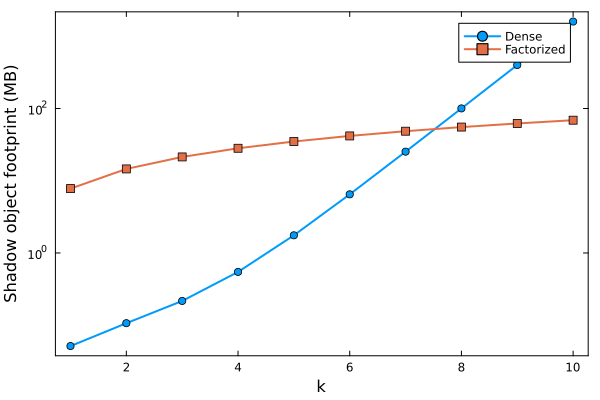

In [16]:
# -----------------------------
# Plots
# -----------------------------
default(grid=false, framestyle=:box, linewidth=2)

p_mem = plot(collect(ks), dense_footprint_MB; marker=:circle,
             xlabel="k", ylabel="Shadow object footprint (MB)",yscale=:log10,
             label="Dense")
plot!(p_mem, collect(ks), fact_footprint_MB; marker=:square,
      label="Factorized")
savefig(p_mem, "single_pauli_memory_vs_k.png")
p_mem


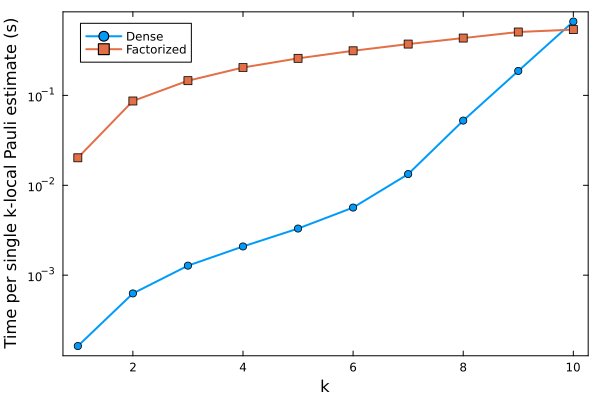

In [15]:
p_time = plot(collect(ks), dense_time_s; marker=:circle,
              xlabel="k", ylabel="Time per single k-local Pauli estimate (s)", label="Dense", yscale=:log10)
plot!(p_time, collect(ks), fact_time_s; marker=:square,
      label="Factorized")
savefig(p_time, "single_pauli_time_vs_k.png")
p_time


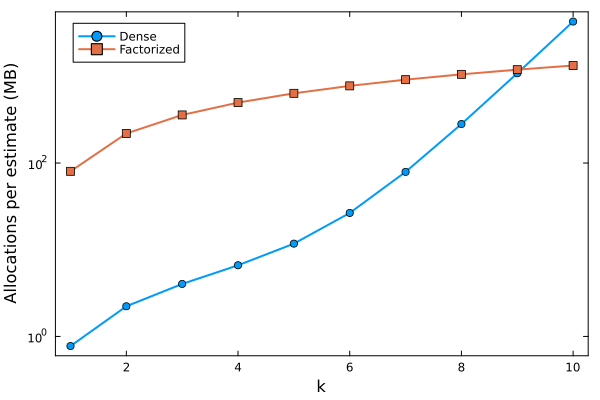

In [12]:
p_alloc = plot(collect(ks), dense_alloc_MB; marker=:circle,
               xlabel="k", ylabel="Allocations per estimate (MB)",
               yaxis=:log10, label="Dense")
plot!(p_alloc, collect(ks), fact_alloc_MB; marker=:square,
      label="Factorized")
savefig(p_alloc, "single_pauli_alloc_vs_k.png")
p_alloc
